In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, balanced_accuracy_score, matthews_corrcoef, precision_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

import shap


In [40]:
#Load datasets
data_small = pd.read_csv('training_small.csv')
data_med = pd.read_csv('training_medium.csv')
data_large = pd.read_csv('training_large.csv')

In [41]:
data_med["Evinced Interaction"].value_counts()

0    167548
1       347
Name: Evinced Interaction, dtype: int64

# **Model Selection**

### **Create the Functions**

Create functions for:

(1) Pre-processing the data  
(2) Training a model, making predictions, and calculating performance metrics  
(3) Running a model on multiple random seeds and calculating the average of the performance metrics.

In [42]:
def preprocess(seed, undersampling_val, oversampling_val, dataframe):
  '''
  Read in a dataframe, undersample the majority class, split data into features and labels (X and y), split into train
  and validation, possibly oversample the minority class for the train data (depending on the input value), normalize data.
  Returns the X_train, X_val, y_train, y_val.
  '''
  #Read in data
  d = dataframe

  #Sampling: undersample majority class
  df_0 = d[d["Evinced Interaction"] == 0]
  df_1 = d[d['Evinced Interaction'] == 1]
  df_0 = df_0.sample(undersampling_val, random_state = seed)  #num 0's you want to keep
  df = pd.concat([df_0, df_1])

  #X, y split
  X = df[['Length of Target coding region', 'Upstream gene (same strand) overlaps target start codon',
               'Distance to upstream gene (same strand) from target start codon', 'Upstream gene (either strand) overlaps target start codon',
               'Distance to upstream gene (either strand) from target start codon', 'Are there sRNA:target homologs (16S relatives)?',
               'Number of sRNA:target homologs (16S relatives)', 'Seed of length 7 bps', 'RNAplex: energy considering accessibility'
               #,'correlations expression', 'correlations ICA', 'distances expression', 'distances ICA', 'is same component', 'component score'
               ]]#.to_numpy()
  y = df[['Evinced Interaction']]#.to_numpy()

  #Find the minority and majority class
  class_counts = y.value_counts()
  minority_class = class_counts.idxmin()
  majority_class = class_counts.idxmax()

  #Train/validation split
  X = X.to_numpy()
  y = y.to_numpy()
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = seed)

  #Sampling: oversample minority class
  if oversampling_val > class_counts[minority_class]: #only oversample if inputted oversampling_value is greater than number of 1's
    smote = SMOTE(sampling_strategy = {minority_class[0]: oversampling_val}, random_state = seed)
    #upsampler = RandomOverSampler(sampling_strategy = {minority_class: upsample_to}, random_state = rand_state)
    X_train, y_train = smote.fit_resample(X_train, y_train)

  #Feature scaling
  scaler = StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)
  X_val = scaler.transform(X_val)

  return X_train, X_val, y_train, y_val


In [43]:
def modeling(modelActual, seed, undersampling_val, oversampling_val, dataframe):
  '''
  Takes in the actual model, seed, and preprocess() inputs. Runs the preprocess() funtion, creates and fits a model,
  makes predictions on validation data.
  Returns the 5 accuracy measures for the given model.
  '''
  #Get data
  X_train, X_val, y_train, y_val = preprocess(seed, undersampling_val, oversampling_val, dataframe)
  y_train = y_train.ravel()
  y_val = y_val.ravel()

  #Fit model and make predictions
  model = modelActual
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)

  #Get accuracy measures
  f1 = f1_score(y_val, y_pred, average= "weighted")
  bam = balanced_accuracy_score(y_val, y_pred)
  mcc = matthews_corrcoef(y_val, y_pred)
  cm = confusion_matrix(y_val, y_pred)
  tpr = cm[1][1]/(cm[1][0] + cm[1][1])
  fpr = cm[0][1]/(cm[0][0] + cm[0][1])
  roc = roc_auc_score(y_val, y_pred)

  return f1, bam, mcc, tpr, fpr, roc


In [44]:
def avgScores(seeds, undersampling_val, oversampling_val, dataframe): #hard code the model into the function
  '''
  Takes in a list of seeds and sampling_val's. Runs the modeling() function.
  Returns the average of the seeds for the 5 accuracy measures.
  '''
  f1_scores = []
  bam_scores = []
  mcc_scores = []
  tpr_scores = []
  fpr_scores = []
  roc_scores = []

  for i in seeds:
    f1, bam, mcc, tpr, fpr, roc = modeling(
            GradientBoostingClassifier(random_state = i)
            #RandomForestClassifier(random_state = i)
            #MLPClassifier(hidden_layer_sizes=(50,), activation='relu', learning_rate = 'adaptive', max_iter = 1000, alpha = 0.0001, random_state = i)
            #LogisticRegression(random_state = i)
            #svm.SVC(random_state = i)
            #KNeighborsClassifier()
            , i, undersampling_val, oversampling_val, dataframe)
    f1_scores.append(f1)
    bam_scores.append(bam)
    mcc_scores.append(mcc)
    tpr_scores.append(tpr)
    fpr_scores.append(fpr)
    roc_scores.append(roc)

  avg_f1  = sum(f1_scores)  / len(f1_scores)
  avg_bam = sum(bam_scores) / len(bam_scores)
  avg_mcc = sum(mcc_scores) / len(mcc_scores)
  avg_tpr = sum(tpr_scores) / len(tpr_scores)
  avg_fpr = sum(fpr_scores) / len(fpr_scores)
  avg_roc = sum(roc_scores) / len(roc_scores)

  return avg_f1, avg_bam, avg_mcc, avg_tpr, avg_fpr, avg_roc


### **Tune Hyperparameters: Try Diffrent Models and Sample Sizes**

In [9]:
seeds = [1, 2, 3, 4, 5]

In [10]:
### Small Dataset

print('Sample 300:', avgScores(seeds, 300, 0, data_small))
print('Sample 400:', avgScores(seeds, 400, 0, data_small))
print('Sample 500:', avgScores(seeds, 500, 0, data_small))
print('Sample 600:', avgScores(seeds, 600, 0, data_small))
print('Sample 750:', avgScores(seeds, 750, 0, data_small))
print('Sample 1000:', avgScores(seeds, 1000, 0, data_small))

Sample 300: (0.7566561653248005, 0.6822712914797663, 0.39874241485670775, 0.4765752508361204, 0.11203266787658803, 0.6822712914797663)
Sample 400: (0.7698217901944008, 0.6262786863375328, 0.32554708317373265, 0.31317391304347825, 0.06061654036841261, 0.6262786863375328)
Sample 500: (0.8210731098225041, 0.6478155611740825, 0.37031025713613497, 0.34689915347810085, 0.05126803112993611, 0.6478155611740825)
Sample 600: (0.8454485637706787, 0.6497041967778604, 0.3855654058189927, 0.3393269990878687, 0.03991860553214786, 0.6497041967778603)
Sample 750: (0.8440889916034244, 0.6144116677236118, 0.3203247327803661, 0.26253151202176694, 0.033708176574543273, 0.6144116677236118)
Sample 1000: (0.8857457465879429, 0.566842444061894, 0.19411948684065786, 0.16299145299145298, 0.029306564867664957, 0.566842444061894)


In [29]:
### Medium Dataset

print('Sample 1000:', avgScores(seeds, 1000, 0, data_med))
print('Sample 1100:', avgScores(seeds, 1100, 0, data_med))
print('Sample 1200:', avgScores(seeds, 1200, 0, data_med))
print('Sample 1300:', avgScores(seeds, 1300, 0, data_med))
print('Sample 1400:', avgScores(seeds, 1400, 0, data_med))
print('Sample 1500:', avgScores(seeds, 1500, 0, data_med))


Sample 1000: (0.7111751522396957, 0.6097121020743235, 0.2422842847256908, 0.35624410919224436, 0.1368199050435976, 0.6097121020743235)
Sample 1100: (0.7247860123233136, 0.5969590634009239, 0.22934680436564178, 0.3063549423549424, 0.11243681555309462, 0.5969590634009239)
Sample 1200: (0.7511462209593104, 0.6108736399819369, 0.27050107376185706, 0.3055070408081822, 0.08375976084430828, 0.6108736399819369)
Sample 1300: (0.781759747583474, 0.6228766461985039, 0.30035620676435704, 0.3190305992664345, 0.0732773068694266, 0.6228766461985038)
Sample 1400: (0.7765670952891396, 0.6092300166229889, 0.26713725131817423, 0.29575296906890636, 0.07729293582292858, 0.6092300166229889)
Sample 1500: (0.7803928425448515, 0.599121135498911, 0.2472655880430003, 0.2721927199127624, 0.07395044891494025, 0.599121135498911)


# **Model Selection with Best Threshold**

### **Create the Functions**

The "best threshold" is the classification threshold for predictions where we get the highest TPR while the FPR is still below 0.05. 

Create functions for: 

(1) Calculating the TPR and FPR of a model given a threshold  
(2) Getting the threshold for a model where the TPR is highest while the FPR is still below 0.05  
(3) Training a model, making predictions, and calculating TPR and FPR using the optimal threshold   
(4) running a model on multiple random seeds and calculating the average of the TPR and FPR using the optimal thresholds

In [26]:
def flex_threshold(pred_proba, y, threshold):
  '''
  Helper function. Takes in the pred_proba of a model, the true y values, and the desired threshold for
  assigning to class 0 vs 1. Returns the TPR and FPR for that threshold.
  '''
  y_pred = (pred_proba[:, 1] > threshold).astype('float')
  tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  return tpr, fpr


def highest_tpr(pred_proba, y):
  '''
  Takes in the pred_proba of a model and the true y values. Tries thresholds of 0.05 to 0.95 in increments of 0.05
  and creates a list of all the (threshold, TPR, FPR)'s. Returns the (threshold, TPR, FPR) that has the highest TPR
  where the FPR is still below 0.05.
  '''
  thresh_list = []
  threshold = 0.05
  while(threshold < 1):
    tpr, fpr = flex_threshold(pred_proba, y, threshold)
    thresh_list.append([threshold, tpr, fpr])
    threshold += 0.05
  for i in range(0, len(thresh_list)):
    if thresh_list[i][2] > 0.05:
      pass
    else:
      return thresh_list[i]


In [27]:
def modeling_threshold(modelActual, seed, undersampling_val, oversampling_val, dataframe):
  '''
  Takes in the actual model, seed, and preprocess() inputs. Runs the preprocess() funtion, creates and fits a model,
  makes predictions on validation data using highest_tpr() function.
  Returns the TPR with lowest FPR below 0.05, as well as the best threshold.
  '''
  #Get data
  X_train, X_val, y_train, y_val = preprocess(seed, undersampling_val, oversampling_val, dataframe)
  y_train = y_train.ravel()
  y_val = y_val.ravel()

  #Fit model and make predictions
  model = modelActual
  model.fit(X_train, y_train)
  y_pred = model.predict(X_val)
  y_pred_prob = model.predict_proba(X_val)

  #Get the tpr with lowest fpr
  thresh, tpr, fpr = highest_tpr(y_pred_prob, y_val)

  return tpr, fpr, thresh


In [28]:
def avgScores_threshold(seeds, undersampling_val, oversampling_val, dataframe): #hard code the model into the function
  '''
  Takes in a list of seeds, and sampling_val's. Runs the modeling_threshold() function.
  Returns the average of the seeds for the tpr and fpr, as well as the avg. of the thresholds.
  '''
  tpr_scores = []
  fpr_scores = []
  thresholds = []

  for i in seeds:
    tpr, fpr, thresh = modeling_threshold(
            #GradientBoostingClassifier(random_state = i)
            RandomForestClassifier(random_state = i)
            #MLPClassifier(hidden_layer_sizes=(50,), activation='relu', learning_rate = 'adaptive', max_iter = 1000, alpha = 0.0001, random_state = i)
            #KNeighborsClassifier()
            , i, undersampling_val, oversampling_val, dataframe)
    tpr_scores.append(tpr)
    fpr_scores.append(fpr)
    thresholds.append(thresh)

  avg_tpr = sum(tpr_scores) / len(tpr_scores)
  avg_fpr = sum(fpr_scores) / len(fpr_scores)
  avg_thresh = sum(thresholds) / len(thresholds)

  return avg_tpr, avg_fpr, avg_thresh


### **Try Different Models using Optimal Thresholds**

In [20]:
print('Small, 500:', avgScores_threshold(seeds, 500, 0, data_small))
print('Medium, 1000:', avgScores_threshold(seeds, 1000, 0, data_med))
print('Large, 11000:', avgScores_threshold(seeds, 11000, 0, data_large))

Small, 500: (0.24427677585572322, 0.015758597010709433, 0.51)
Medium, 1000: (0.18379782669673705, 0.02730765071771297, 0.6)
Large, 11000: (0.1892702535794681, 0.036506170542169314, 0.6)


# **Model Performance: ROC Graphs**

Create ROC graphs. Draw both individual RPC graphs for each model (graph_roc_curves()), as well as a single graph with all the ROC curves overlayed (graph_all_curves()).

### **Create Functions**

In [14]:
def graph_roc_curves(modelList, seed, undersampling_val, oversampling_val, dataframe):
  '''
  Takes in a list of models. Graphs the roc curve for all of them.
  '''
  #Get data
  X_train, X_val, y_train, y_val = preprocess(seed, undersampling_val, oversampling_val, dataframe)
  y_train = y_train.ravel()
  y_val = y_val.ravel()

  for model in modelList:
    #Fit model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)

    #Get roc
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob[:, 1])

    #Plot the roc curve
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(model)
    plt.axvline(x = 0.05, ls = '--', color = 'black', lw = 0.8)
    plt.show()

  return None


In [15]:
def graph_all_curves(modelList, seed, undersampling_val, oversampling_val, dataframe):
  '''
  Takes in a list of models. Graphs the roc curve for all of them on top of each other.
  '''
  #Get data
  X_train, X_val, y_train, y_val = preprocess(seed, undersampling_val, oversampling_val, dataframe)
  y_train = y_train.ravel()
  y_val = y_val.ravel()

  #l = []
  plt.figure(0).clf()
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.axvline(x = 0.05, ls = '--', color = 'black', lw = 0.8)

  for model in modelList:
    #Fit model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)

    #Get roc
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob[:, 1])

    plt.plot(fpr, tpr, label = model)
    plt.legend(bbox_to_anchor=(0, -0.2))

  return None


### **Graph ROC Curves**

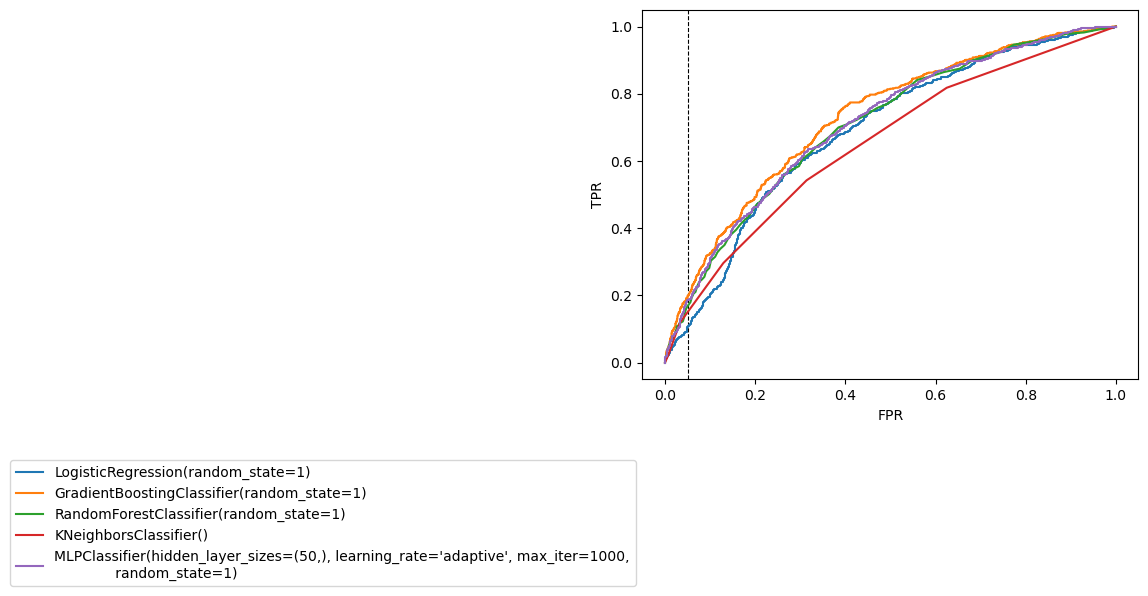

In [16]:
### Test the graph_roc_curves() function ###
seed = 1
models = [LogisticRegression(random_state = seed),
          GradientBoostingClassifier(random_state = seed),
          RandomForestClassifier(random_state = seed),
          #svm.SVC(random_state = seed, probability= True),
          KNeighborsClassifier(),
          MLPClassifier(hidden_layer_sizes=(50,), activation='relu', learning_rate = 'adaptive',
                        max_iter = 1000, alpha = 0.0001, random_state = seed)
]

#graph_roc_curves(models, seed, 500, 0, data_small)
#graph_all_curves(models, seed, 1000, 0, data_med)
graph_all_curves(models, seed, 11000, 0, data_large)

# **Model Performance: Bar Graphs of TPR/FPR**

Create bar graphs for the optimal models, where the FPR of each model is overlayed on the TPR of that model.

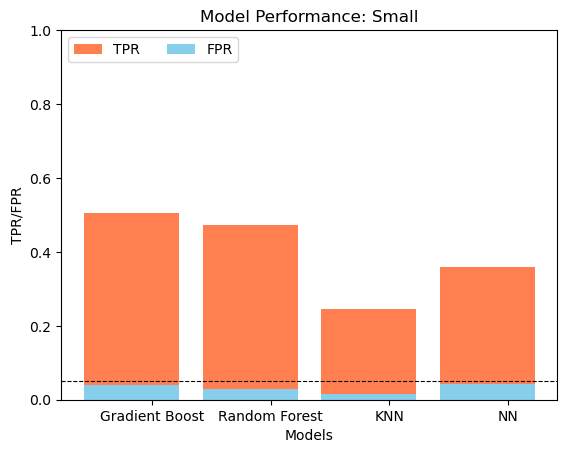

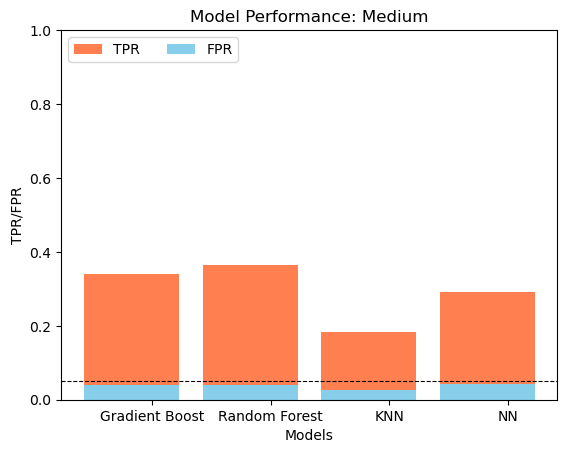

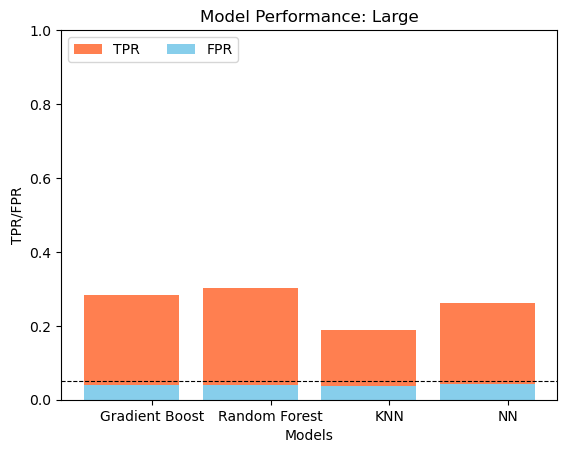

In [17]:
#TPR and FPR are the optimal for each model

rg = np.arange(4)
width = 0.35
labels = ['Gradient Boost','Random Forest', 'KNN', 'NN']

### Small Dataset
TPR_small = [0.5058, 0.4737, 0.2442, 0.3583]
FPR_small = [0.0396, 0.0299, 0.0157, 0.0434]
# 1. Create bar plot with TPR results
plt.bar(labels, TPR_small, color= 'coral', label= 'TPR')
# 2. Create bar plot with FPR results
plt.bar(labels, FPR_small, color= 'skyblue', label= 'FPR')
plt.axhline(y=0.05, ls = "--", color = "black", lw = 0.8)
plt.xticks(rg + width/2, labels)
plt.xlabel("Models")
plt.ylabel("TPR/FPR")
plt.ylim([0,1])
plt.title('Model Performance: Small')
plt.legend(loc= 'upper left', ncol=2)
plt.show()

### Medium Dataset
TPR_med = [0.3405, 0.3648, 0.1837, 0.2913]
FPR_med = [0.0385, 0.0395, 0.0273, 0.0424]
# 1. Create bar plot with TPR results
plt.bar(labels, TPR_med, color= 'coral', label= 'TPR')
# 2. Create bar plot with FPR results
plt.bar(labels, FPR_med, color= 'skyblue', label= 'FPR')
plt.axhline(y=0.05, ls = "--", color = "black", lw = 0.8)
plt.xticks(rg + width/2, labels)
plt.xlabel("Models")
plt.ylabel("TPR/FPR")
plt.ylim([0,1])
plt.title('Model Performance: Medium')
plt.legend(loc= 'upper left', ncol=2)
plt.show()

### Large Dataset
TPR_large = [0.2844, 0.3014, 0.1892, 0.2625]
FPR_large = [0.0405, 0.0399, 0.0365, 0.0432]
# 1. Create bar plot with TPR results
plt.bar(labels, TPR_large, color= 'coral', label= 'TPR')
# 2. Create bar plot with FPR results
plt.bar(labels, FPR_large, color= 'skyblue', label= 'FPR')
plt.axhline(y=0.05, ls = "--", color = "black", lw = 0.8)
plt.xticks(rg + width/2, labels)
plt.xlabel("Models")
plt.ylabel("TPR/FPR")
plt.ylim([0,1])
plt.title('Model Performance: Large')
plt.legend(loc= 'upper left', ncol=2)
plt.show()

# **Feature Importance**

Get feature importance using Shapely analysis.

  0%|          | 0/100 [00:00<?, ?it/s]

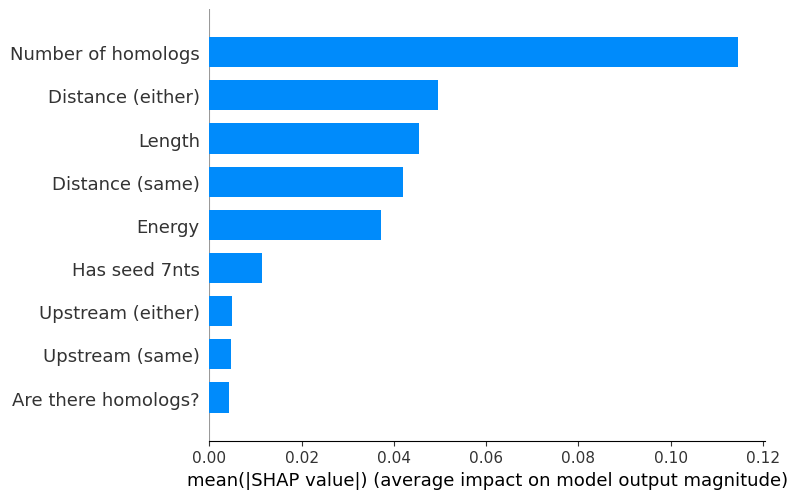

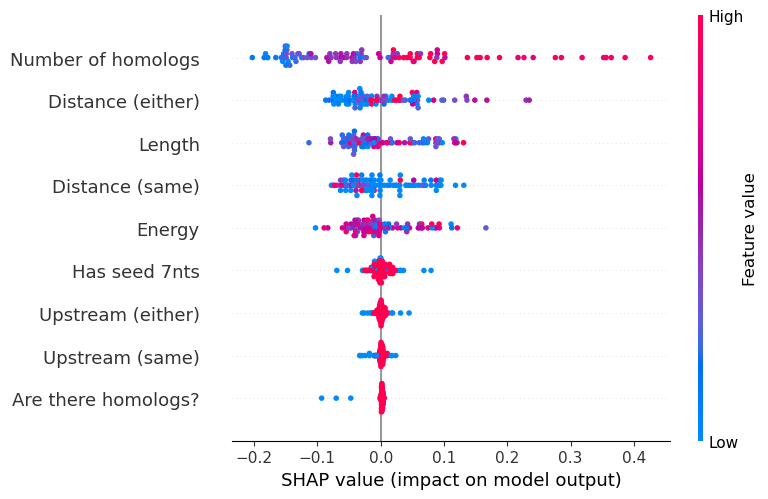

In [18]:
#Get data
X_train, X_val, y_train, y_val = preprocess(1, 11000, 0, data_large)
y_train = y_train.ravel()
y_val = y_val.ravel()

#Fit model and make predictions
model = RandomForestClassifier(random_state = 1)
model.fit(X_train, y_train)

def model_predict(X_val):
  return model.predict_proba(X_val)[:, 1]

features = ['Length', 'Upstream (same)', 'Distance (same)', 'Upstream (either)', 'Distance (either)',
            'Are there homologs?', 'Number of homologs', 'Has seed 7nts', 'Energy', 'Correlation Expression',
            'Correlation ICA', 'Distance Expression', 'Distance ICA', 'Is Same Component', 'Component Score']
X_sampled = shap.sample(X_train, 100, random_state = 1)
explainer = shap.KernelExplainer(model_predict, X_sampled, feature_names = features)
shap_values = explainer.shap_values(X_sampled)

plt.rcParams['figure.autolayout'] = True

# Create plots
plt.figure(figsize = (12, 8))
shap.summary_plot(shap_values, X_sampled, feature_names = features, plot_type = "bar", show = False)
plt.tight_layout()
# plt.savefig('Shapley1.png', dpi = 300, bbox_inches='tight')
plt.show()

plt.figure(figsize = (12, 8))
shap.summary_plot(shap_values, X_sampled, feature_names = features, plot_type = "dot", show = False)
plt.tight_layout()
# plt.savefig('Shapley2.png', dpi = 300, bbox_inches='tight')
plt.show()


# **Testing**

### **Load testing data**

In [20]:
#Load testing data
test_small = pd.read_csv('testing_small.csv')
test_med = pd.read_csv('testing_medium.csv')
test_large = pd.read_csv('testing_large.csv')

In [21]:
#Rename variables in test_med
test_med = test_med.rename(columns={"Target Length": "Length of Target coding region",
                            "upstream same strand": "Upstream gene (same strand) overlaps target start codon",
                            "distance same strand": "Distance to upstream gene (same strand) from target start codon",
                            "upstream any strand": "Upstream gene (either strand) overlaps target start codon",
                            "distance any strand": "Distance to upstream gene (either strand) from target start codon",
                            "has pair homologs": "Are there sRNA:target homologs (16S relatives)?",
                            "Homologs": "Number of sRNA:target homologs (16S relatives)",
                            "Seed": "Seed of length 7 bps",
                            "Energy": "RNAplex: energy considering accessibility"})

### **Create functions for Testing**

Caclulate performance metrics for the testing data using the models selected earlier with the optimal thresholds.

In [34]:
def test_model(random_state, undersampling_val, oversampling_val, threshold, ActualModel, train_data, test_data, curve_bool):
  '''
  Train model on the train data. Use the test data to make predictions and get TPR and FPR values at desired threshold.
  Optionally graph ROC curves depending on boolean value of curve_bool.
  '''
  #Sampling: undersample majority class
  df_0 = train_data[train_data["Evinced Interaction"] == 0]
  df_1 = train_data[train_data['Evinced Interaction'] == 1]
  df_0 = df_0.sample(undersampling_val, random_state = random_state)  #num 0's you want to keep
  df = pd.concat([df_0, df_1])

  #X, y split
  X_train = df[['Length of Target coding region', 'Upstream gene (same strand) overlaps target start codon',
          'Distance to upstream gene (same strand) from target start codon', 'Upstream gene (either strand) overlaps target start codon',
          'Distance to upstream gene (either strand) from target start codon', 'Are there sRNA:target homologs (16S relatives)?',
          'Number of sRNA:target homologs (16S relatives)', 'Seed of length 7 bps', 'RNAplex: energy considering accessibility'
          ,'correlations expression', 'correlations ICA', 'distances expression', 'distances ICA', 'is same component', 'component score'
          ]].to_numpy()
  y_train = df[['Evinced Interaction']].to_numpy()

  #Feature scaling
  scaler = StandardScaler().fit(X_train)
  X_train = scaler.transform(X_train)

  #Train model
  y_train = y_train.ravel()
  model = ActualModel
  model.fit(X_train, y_train)


  #Test model
  X_test = test_data[['Length of Target coding region', 'Upstream gene (same strand) overlaps target start codon',
          'Distance to upstream gene (same strand) from target start codon', 'Upstream gene (either strand) overlaps target start codon',
          'Distance to upstream gene (either strand) from target start codon', 'Are there sRNA:target homologs (16S relatives)?',
          'Number of sRNA:target homologs (16S relatives)', 'Seed of length 7 bps', 'RNAplex: energy considering accessibility'
          ,'correlations expression', 'correlations ICA', 'distances expression', 'distances ICA', 'is same component', 'component score'
          ]]
  y_test = test_data[['Evinced Interaction']]
  X_test = scaler.transform(X_test.to_numpy())

  y_pred = model.predict(X_test)
  y_pred_prob = model.predict_proba(X_test)

  # cm = confusion_matrix(y_test, y_pred)
  # tpr = cm[1][1]/(cm[1][0] + cm[1][1])
  # fpr = cm[0][1]/(cm[0][0] + cm[0][1])

  #Plot ROC curve
  if curve_bool:     
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_prob[:, 1])
    plt.plot(fpr2, tpr2)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(model)
    plt.axvline(x = 0.05, ls = '--', color = 'black', lw = 0.8)
    plt.show()

  tpr, fpr = flex_threshold(y_pred_prob, y_test, threshold = threshold)
  return tpr, fpr


In [38]:
def test_avgScores(seeds, undersampling_val, oversampling_val, threshold, ActualModel, train_data, test_data):
  '''
  Runs test_model() function on a list of seeds and gets the average tpr and fpr values. Does not graph ROC curves.
  '''
  tpr_scores = []
  fpr_scores = []

  for i in seeds:
    tpr, fpr = test_model(i, undersampling_val, oversampling_val, threshold, ActualModel, train_data, test_data, False)
    tpr_scores.append(tpr)
    fpr_scores.append(fpr)

  avg_tpr = sum(tpr_scores) / len(tpr_scores)
  avg_fpr = sum(fpr_scores) / len(fpr_scores)

  return avg_tpr, avg_fpr

### **Calculate performance on the testing data**

In [37]:
print("Small:", test_avgScores(seeds, 500, 0, 0.4, GradientBoostingClassifier(random_state = 1), data_small, test_small))
print("Medium:", test_avgScores(seeds, 1000, 0, 0.54, RandomForestClassifier(random_state = 1), data_med, test_med))
print("Large:", test_avgScores(seeds, 11000, 0, 0.53, RandomForestClassifier(random_state = 1), data_large, test_large))

Small: (0.5565217391304348, 0.060378966946952384)
Medium: (0.3804878048780488, 0.050595215014153316)
Large: (0.12707006369426752, 0.03174086847468255)


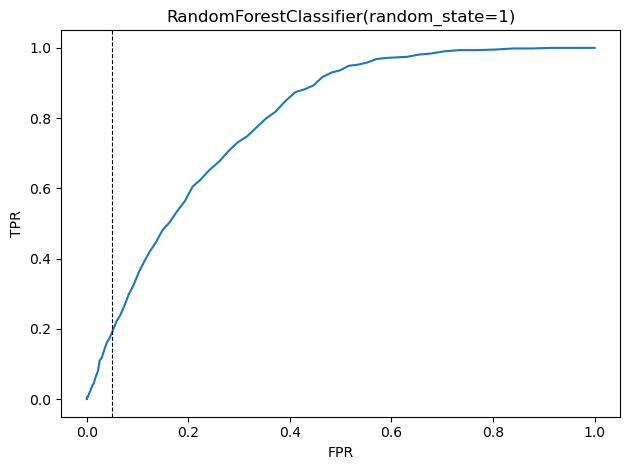

(0.1178343949044586, 0.029510895124627685)

In [36]:
test_model(1, 11000, 0, 0.53, RandomForestClassifier(random_state = 1), data_large, test_large, True)